# Behavior and Stability Analysis

This notebook turns the models from 03_modelling into a view of behavior and stability, focusing on interpretability, stability, calibration, and segment analysis.

In [1]:
# Standard library imports
import pickle
from pathlib import Path

# IPython/Jupyter-related imports
from IPython.display import clear_output, display

# Core scientific and data analysis libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning/modeling libraries
import shap
import xgboost as xgb

from venn_abers import VennAbers
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score

In [2]:
XGBOOST_FEATURES = [
    "xgb_employment_length_years",
    "xgb_annual_income",
    "xgb_loan_amount_requested",
    "xgb_fico_score_high",
    "xgb_debt_to_income_ratio",
    "xgb_total_credit_lines",
    "xgb_revolving_balance",
    "xgb_revolving_utilization_rate",
    "xgb_revolving_accounts_count",
    "xgb_months_since_oldest_revolving",
    "xgb_months_since_oldest_installment",
    "xgb_total_installment_credit_limit",
    "xgb_satisfactory_bankcard_accounts",
    "xgb_bankcard_utilization",
    "xgb_bankcard_open_to_buy",
    "xgb_months_since_recent_bankcard",
    "xgb_percent_bankcard_over_75pct_limit",
    "xgb_months_since_recent_inquiry",
    "xgb_accounts_opened_past_12months",
    "xgb_accounts_opened_past_24months",
    "xgb_total_high_credit_limit",
    "xgb_total_balance_excluding_mortgage",
    "xgb_total_bankcard_limit",
    "xgb_average_current_balance",
    "xgb_mortgage_accounts_count",
    "xgb_percent_trades_never_delinquent",
]

LR_FEATURES = [
    "lr_home_ownership_status_MORTGAGE",
    "lr_home_ownership_status_OWN",
    "lr_state_CO",
    "lr_state_FL",
    "lr_state_GA",
    "lr_state_IL",
    "lr_state_NV",
    "lr_state_NY",
    "lr_state_OR",
    "lr_state_SC",
    "lr_state_WA",
    "lr_income_verification_status_Not Verified",
    "lr_income_verification_status_Verified",
    "lr_loan_purpose_credit_card",
    "lr_loan_purpose_other",
    "lr_loan_purpose_infrequent_sklearn",
    "lr_director",
    "lr_driver",
    "lr_engineer",
    "lr_owner",
    "lr_sales",
    "lr_business",
    "lr_annual_income",
    "lr_loan_amount_requested",
    "lr_fico_score_high",
    "lr_total_credit_lines",
    "lr_revolving_balance",
    "lr_active_revolving_trades",
    "lr_months_since_oldest_revolving",
    "lr_total_installment_credit_limit",
    "lr_bankcard_open_to_buy",
    "lr_months_since_recent_bankcard",
    "lr_percent_bankcard_over_75pct_limit",
    "lr_inquiries_last_6months",
    "lr_months_since_recent_inquiry",
    "lr_accounts_opened_past_12months",
    "lr_accounts_opened_past_24months",
    "lr_total_high_credit_limit",
    "lr_total_bankcard_limit",
]

In [3]:
# Load data and fitted models
DATA_PATH = Path("..") / "data" / "scored_data.parquet"
XGB_MODEL_PATH = Path("..") / "models" / "xgb_model.pkl"
LR_MODEL_PATH = Path("..") / "models" / "lr_model.pkl"

assert DATA_PATH.exists(), "Run previous notebooks to generate scored_data.parquet"

data = pd.read_parquet(DATA_PATH)

with open(XGB_MODEL_PATH, "rb") as f:
    xgb_model = pickle.load(f)

with open(LR_MODEL_PATH, "rb") as f:
    lr_model = pickle.load(f)


train_data = data[data["dataset"] == "train"].copy()
calibration_data = data[data["dataset"] == "calibration"].copy()
validation_data = data[data["dataset"] == "validation"].copy()

print(data[["dataset"]].value_counts().rename_axis("dataset").reset_index(name="count"))

       dataset   count
0        train  917766
1  calibration   48304
2   validation   47902
3         test   45934


# Interpretability

The first sanity check is interpretability: are we seeing the expected drivers for credit risk? The summary below should highlight affordability (DTI), credit quality (FICO), utilization, and recency/credit seeking. If that holds, we know the model is leaning on the right economic levers instead of spurious artifacts.

100%|===================| 1498/1500 [00:18<00:00]        

,mean_abs_shap
xgb_loan_amount_requested,0.201132
xgb_fico_score_high,0.198752
xgb_debt_to_income_ratio,0.178862
xgb_accounts_opened_past_24months,0.173688
xgb_total_high_credit_limit,0.107610
xgb_months_since_recent_inquiry,0.107319
xgb_percent_bankcard_over_75pct_limit,0.106997
xgb_annual_income,0.104563
xgb_total_bankcard_limit,0.097844
xgb_revolving_balance,0.088338


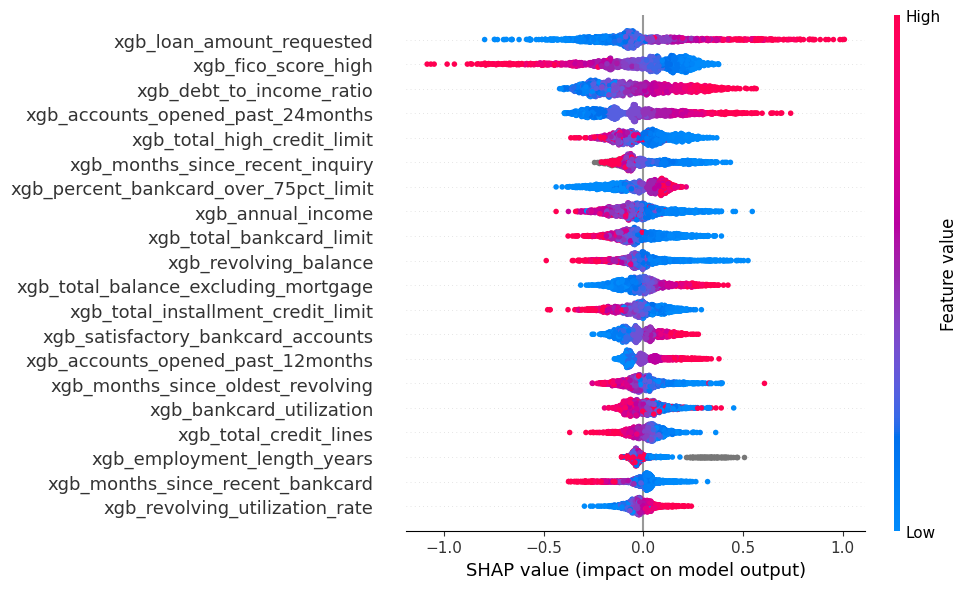

In [4]:
# Global SHAP read (sampled for speed)
BACKGROUND_SAMPLE = min(len(train_data), 1500)
EXPLANATION_SAMPLE = min(len(validation_data), 1500)

background_inputs = train_data[XGBOOST_FEATURES].sample(BACKGROUND_SAMPLE, random_state=34)
to_explain = validation_data[XGBOOST_FEATURES].sample(EXPLANATION_SAMPLE, random_state=34)

explainer = shap.TreeExplainer(xgb_model, background_inputs)
shap_values = explainer.shap_values(to_explain)

shap.summary_plot(shap_values, to_explain, show=False, plot_size=(10, 6))
plt.tight_layout()

shap_abs = pd.Series(np.abs(shap_values).mean(axis=0), index=XGBOOST_FEATURES)
display(shap_abs.sort_values(ascending=False).head(15).to_frame("mean_abs_shap"))

This SHAP summary looks broadly consistent with a credit risk setting: risk is mostly driven by affordability (DTI), credit quality (FICO), credit utilization, and credit depth/recency signals. That’s a good sign because the model seems to be picking up interpretable patterns rather than spurious variables.

The model is using the “right” signals:
- Loan amount requested being top-ranked is expected: larger exposure at origination typically correlates with higher risk (and may also reflect borrower selection dynamics).
- FICO score high has the expected directionality: higher FICO values consistently push predictions toward lower default risk.
- DTI ratio appears as a strong positive risk driver, which aligns with affordability constraints.
- Recency/credit seeking behavior variables (months_since_recent_inquiry, accounts_opened_past_12/24months) show up high, which typically indicates risk coming from recent credit expansion and inquiries — also consistent.

We now move to interpretability for the logistic regression baseline. Unlike XGBoost — where interpretability typically requires post-hoc tools such as SHAP to explain model behavior — logistic regression is inherently interpretable due to its linear structure in log-odds space. Each coefficient directly represents how a feature shifts the model’s predicted log-odds of default, holding all other variables constant. Since all features were scaled using Min-Max scaling, coefficient magnitudes are more directly comparable across variables. Additionally, we previously filtered highly correlated features, which helps reduce coefficient instability and improves interpretability.

So now, we need to: 
- inspect the model summary, including coefficient estimates and statistical significance,
- convert coefficients from log-odds to odds ratios (OR) for easier interpretation,
- compute 95% confidence intervals to assess uncertainty,
- and visualize the strongest effects using an odds-ratio plot.

This provides a transparent baseline explanation of risk drivers and serves as a useful reference point for comparing against the XGBoost model.

                                      Results: Logit
Model:                       Logit                    Method:                   MLE        
Dependent Variable:          default_binary           Pseudo R-squared:         0.057      
Date:                        2026-01-02 21:44         AIC:                      718980.1156
No. Observations:            917766                   BIC:                      719449.3035
Df Model:                    39                       Log-Likelihood:           -3.5945e+05
Df Residuals:                917726                   LL-Null:                  -3.8109e+05
Converged:                   1.0000                   LLR p-value:              0.0000     
No. Iterations:              7.0000                   Scale:                    1.0000     


,coef_log_odds,odds_ratio,or_conf_low,or_conf_high,std_err,z_value,p_value,effect_direction
lr_annual_income,-7.337489,0.000651,0.000512,0.000826,0.121837,-60.223625,0.000000e+00,decreases default risk
lr_accounts_opened_past_24months,4.252483,70.279670,57.941919,85.244537,0.098492,43.175765,0.000000e+00,increases default risk
const,3.961709,52.547060,45.521019,60.657550,0.073233,54.096972,0.000000e+00,increases default risk
lr_fico_score_high,-1.776805,0.169178,0.159454,0.179495,0.030202,-58.830286,0.000000e+00,decreases default risk
lr_active_revolving_trades,1.663403,5.277238,4.615455,6.033910,0.068365,24.331316,9.142501e-131,increases default risk
lr_months_since_recent_bankcard,-1.625565,0.196800,0.167552,0.231154,0.082090,-19.802137,2.853270e-87,decreases default risk
lr_loan_amount_requested,1.548053,4.702307,4.476387,4.939629,0.025121,61.623016,0.000000e+00,increases default risk
lr_total_credit_lines,-1.470851,0.229730,0.204503,0.258069,0.059349,-24.783086,1.364422e-135,decreases default risk
lr_accounts_opened_past_12months,1.128171,3.090000,2.639849,3.616913,0.080333,14.043704,8.419407e-45,increases default risk
lr_total_high_credit_limit,-0.762167,0.466654,0.400025,0.544382,0.078605,-9.696196,3.129478e-22,decreases default risk


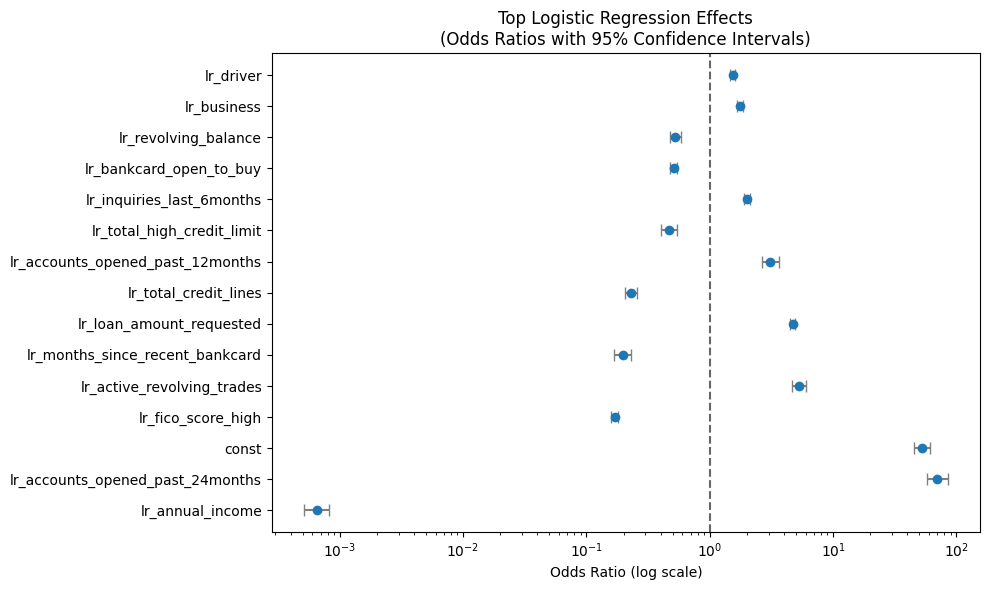

In [5]:
# Model summary
print("\n".join(str(lr_model.summary2()).split("\n")[:10]))

coefs = lr_model.params
stderr = lr_model.bse
pvals = lr_model.pvalues
conf_int = lr_model.conf_int()
conf_int.columns = ["conf_low", "conf_high"]

interpret_df = pd.DataFrame(
    {
        "coef_log_odds": coefs,
        "std_err": stderr,
        "z_value": coefs / stderr,
        "p_value": pvals,
    }
).join(conf_int)

# Odds ratio and CI in OR space
interpret_df["odds_ratio"] = np.exp(interpret_df["coef_log_odds"])
interpret_df["or_conf_low"] = np.exp(interpret_df["conf_low"])
interpret_df["or_conf_high"] = np.exp(interpret_df["conf_high"])

# Add sign direction for readability
interpret_df["effect_direction"] = np.where(
    interpret_df["coef_log_odds"] > 0, "increases default risk", "decreases default risk"
)

# Rank by absolute z-value (more stable than abs(coef))
interpret_df = interpret_df.reindex(interpret_df["coef_log_odds"].abs().sort_values(ascending=False).index)

# Show top features
topN = 15
display(
    interpret_df[
        [
            "coef_log_odds",
            "odds_ratio",
            "or_conf_low",
            "or_conf_high",
            "std_err",
            "z_value",
            "p_value",
            "effect_direction",
        ]
    ].head(topN)
)

# Odds ratio plot (top N by |z|)
top_features = interpret_df.index[:topN]
plot_df = interpret_df.loc[top_features].copy()

plt.figure(figsize=(10, 6))

# Errors in OR space
x = plot_df["odds_ratio"].values
xerr = np.vstack([x - plot_df["or_conf_low"].values, plot_df["or_conf_high"].values - x])

plt.errorbar(x, plot_df.index, xerr=xerr, fmt="o", capsize=4, ecolor="gray")

plt.axvline(1, color="black", linestyle="--", alpha=0.6)
plt.xscale("log")
plt.xlabel("Odds Ratio (log scale)")
plt.title("Top Logistic Regression Effects\n(Odds Ratios with 95% Confidence Intervals)")
plt.tight_layout()
plt.show()

Overall, the logistic regression baseline recovers a set of drivers that are also highly consistent with standard credit risk intuition. The model is statistically significant (LLR p-value ≈ 0.0) and converged properly, suggesting the optimization behaved as expected. That said, the pseudo R² (~0.057) indicates that the linear log-odds specification captures only a modest portion of the explainable variation — which is common in raw credit risk settings and is one of the reasons tree-based models often outperform LR.

Because features were Min-Max scaled, each coefficient should be interpreted as the change in log-odds associated with moving that feature from its minimum (0) to its maximum (1) within the observed dataset range (holding all other variables constant). This makes coefficient magnitudes more comparable across continuous features than they would be in raw units.

Key LR signals:
- Higher loan amount (`lr_loan_amount_requested`) increases default risk.
- Higher annual income (`lr_annual_income`) and FICO score (`lr_fico_score_high`) reduce risk.
- Recent credit activity—accounts opened in past 12/24 months and recent inquiries—raise risk (“credit expansion”).
- Greater utilization (`lr_percent_bankcard_over_75pct_limit`) increases risk; more open-to-buy lowers it.
- Homeownership (MORTGAGE/OWN) is protective vs. baseline.
- State and occupation dummies have effects but should be used cautiously due to stability/fairness concerns.

A notable point here is that many coefficients are highly significant (very small p-values), which is expected given the large sample size. Statistical significance here does not necessarily imply operational relevance — effect size and stability over time/segments matter more.

A positive takeaway is that LR and XGBoost highlight largely the same core risk signals.
- Logistic regression provides a clean and transparent baseline explanation (“direction and approximate magnitude” of effects) and helps validate that the dataset is behaving as expected under a standard credit-risk lens.
- XGBoost + SHAP provides a richer picture of the decision surface and is better suited for understanding complex relationships and building higher-performing models — provided we apply leakage checks, stability analysis, and calibration.

In short, both models tell a consistent story: default risk is primarily driven by a combination of exposure (loan amount), credit quality (FICO), affordability/constraints (DTI/income), utilization pressure, and recency of credit expansion.

## Top features by time cohort

Stability check: Do the most important features shift significantly between early and late cohorts? If the model is relying on different signals over time, we should implement monitoring and possibly retrain features to prevent hidden drift. Below, we split the validation dataset into quantiles based on issuance date and compare model interpretability at the start versus the end of the period.

2007-07-01 00:00:00 2017-01-01 00:00:00
2017-02-01 00:00:00 2017-03-01 00:00:00


,early,late,delta_late_minus_early
xgb_fico_score_high,0.190308,0.194727,0.004418
xgb_loan_amount_requested,0.181136,0.193474,0.012338
xgb_debt_to_income_ratio,0.180337,0.177411,-0.002926
xgb_accounts_opened_past_24months,0.157761,0.173818,0.016057
xgb_months_since_recent_inquiry,0.110341,0.108297,-0.002044
xgb_total_high_credit_limit,0.106849,0.106402,-0.000446
xgb_percent_bankcard_over_75pct_limit,0.092969,0.106290,0.013320
xgb_annual_income,0.110106,0.103936,-0.006170
xgb_total_bankcard_limit,0.093320,0.097760,0.004439
xgb_total_installment_credit_limit,0.092425,0.090010,-0.002415


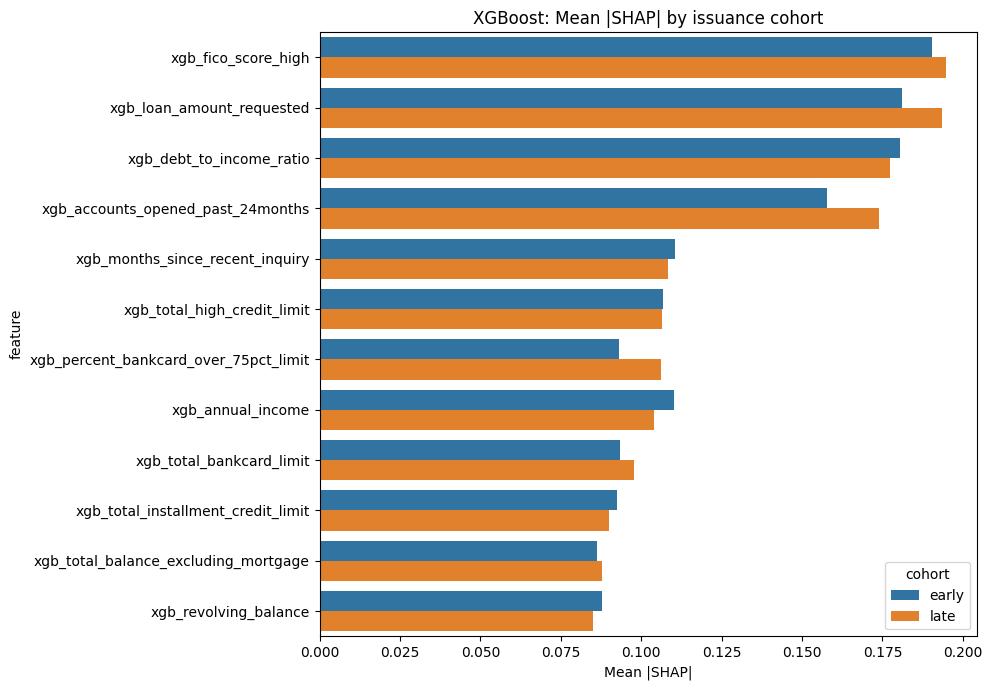

In [6]:
cohorts = {
    "early": calibration_data,
    "late": validation_data,
}
print(calibration_data["loan_issue_date"].min(), calibration_data["loan_issue_date"].max())
print(validation_data["loan_issue_date"].min(), validation_data["loan_issue_date"].max())


importance_frames = []
for cohort_name, df_slice in cohorts.items():
    if df_slice.empty:
        continue
    sample_size = min(len(df_slice), 800)
    sampled = df_slice[XGBOOST_FEATURES].sample(sample_size, random_state=34)
    shap_vals = explainer.shap_values(sampled)
    mean_absolute_shap = np.abs(shap_vals).mean(axis=0)
    importance_frames.append(pd.Series(mean_absolute_shap, index=XGBOOST_FEATURES, name=cohort_name))

importance_df = pd.concat(importance_frames, axis=1)
importance_df["delta_late_minus_early"] = importance_df.get("late", 0) - importance_df.get("early", 0)

ranked = importance_df.reindex(importance_df.mean(axis=1).sort_values(ascending=False).head(12).index)

plot_df = ranked.reset_index().melt(
    id_vars="index", value_vars=["early", "late"], var_name="cohort", value_name="mean_abs_shap"
)
plot_df = plot_df.rename(columns={"index": "feature"})

fig, axis = plt.subplots(figsize=(10, 7))
sns.barplot(data=plot_df, x="mean_abs_shap", y="feature", hue="cohort", ax=axis)
axis.set_title("XGBoost: Mean |SHAP| by issuance cohort")
axis.set_xlabel("Mean |SHAP|")
plt.tight_layout()

ranked[["early", "late", "delta_late_minus_early"]]

2007-07-01 00:00:00 2017-01-01 00:00:00
2017-02-01 00:00:00 2017-03-01 00:00:00


,early_mean_abs_phi,late_mean_abs_phi,delta_late_minus_early
lr_loan_amount_requested,0.192852,0.206819,0.013967
lr_annual_income,0.195764,0.203780,0.008015
lr_fico_score_high,0.193304,0.203265,0.009961
lr_accounts_opened_past_24months,0.153032,0.159817,0.006785
lr_total_credit_lines,0.078554,0.078375,-0.000180
lr_bankcard_open_to_buy,0.070026,0.071140,0.001114
lr_active_revolving_trades,0.066289,0.071675,0.005386
lr_inquiries_last_6months,0.064786,0.059304,-0.005482
lr_months_since_recent_bankcard,0.050154,0.051082,0.000928
lr_accounts_opened_past_12months,0.045548,0.048366,0.002818


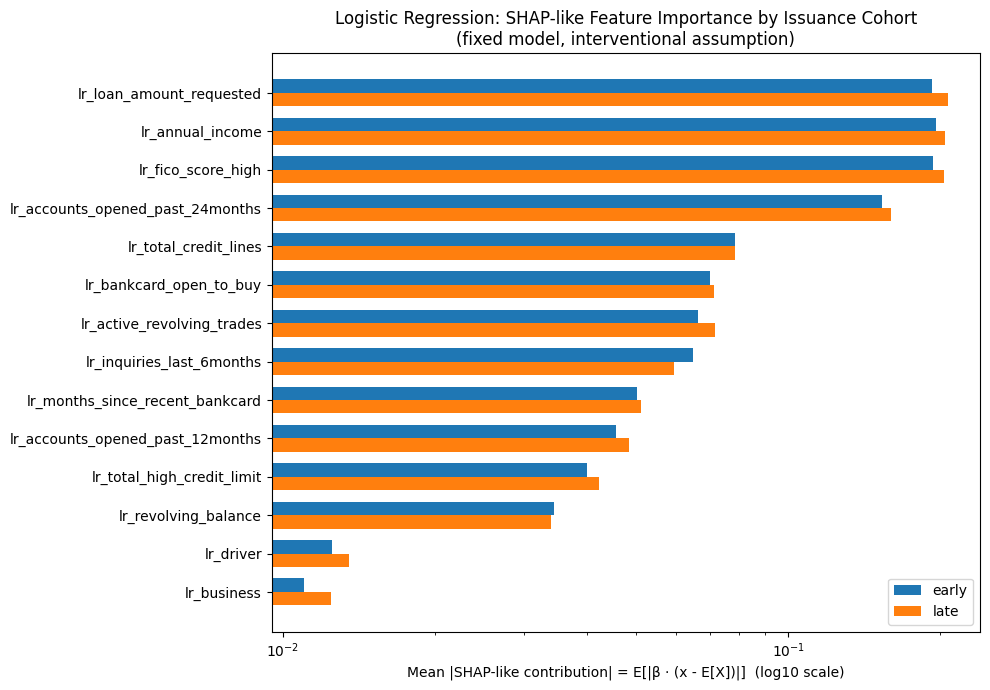

In [7]:
early = calibration_data
late = validation_data
print(early["loan_issue_date"].min(), early["loan_issue_date"].max())
print(late["loan_issue_date"].min(), late["loan_issue_date"].max())

topN = 15
top_features = [f for f in interpret_df.index[:topN] if f != "const"]

beta = lr_model.params.reindex(top_features)

# Background mean (this should match the "background dataset" concept in SHAP)
mu = train_data[top_features].mean()

# SHAP-like contributions for LR (interventional assumption):
# phi_ij = beta_j * (x_ij - mu_j)
early_phi = (early[top_features] - mu).multiply(beta, axis=1)
late_phi = (late[top_features] - mu).multiply(beta, axis=1)

# Importance per cohort: mean(|phi|)
early_imp = early_phi.abs().mean(axis=0)
late_imp = late_phi.abs().mean(axis=0)

importance_df = pd.DataFrame(
    {
        "early_mean_abs_phi": early_imp,
        "late_mean_abs_phi": late_imp,
    }
)
importance_df["delta_late_minus_early"] = (
    importance_df["late_mean_abs_phi"] - importance_df["early_mean_abs_phi"]
)

importance_df["mean_importance"] = importance_df[["early_mean_abs_phi", "late_mean_abs_phi"]].mean(axis=1)
importance_df = importance_df.sort_values("mean_importance", ascending=False)

display(importance_df[["early_mean_abs_phi", "late_mean_abs_phi", "delta_late_minus_early"]])

features_order = importance_df.index.tolist()
y = np.arange(len(features_order))
h = 0.35
eps = 1e-12

plt.figure(figsize=(10, 7))
plt.barh(y - h / 2, importance_df.loc[features_order, "early_mean_abs_phi"] + eps, height=h, label="early")
plt.barh(y + h / 2, importance_df.loc[features_order, "late_mean_abs_phi"] + eps, height=h, label="late")

plt.yticks(y, features_order)
plt.gca().invert_yaxis()
plt.xscale("log", base=10)
plt.xlabel("Mean |SHAP-like contribution| = E[|β · (x - E[X])|]  (log10 scale)")
plt.title(
    "Logistic Regression: SHAP-like Feature Importance by Issuance Cohort\n(fixed model, interventional assumption)"
)
plt.legend()
plt.tight_layout()
plt.show()

Across both models, the story is reassuringly consistent: the top risk drivers remain anchored in the same core credit constructs — exposure (loan amount requested), credit quality (FICO), affordability (DTI / income), utilization pressure, and recent credit seeking / expansion behavior. In the XGBoost cohort comparison, the mean |SHAP| values are highly stable between early and late issuance cohorts, with only small deltas across the top drivers. This suggests that, despite time passing and potential portfolio drift, the model’s reliance on these signals remains structurally similar over time — which is a strong sign for interpretability stability and governance.

For the logistic regression baseline, it is important to distinguish between global coefficient odds ratios (exp(β)) and cohort-aware feature importance. The global odds ratios from the LR summary quantify the structural effect of a one-unit change in a feature (here, 0→1 under Min-Max scaling), and therefore do not change across cohorts. In contrast, the cohort analysis we added for LR estimates how strongly each feature is actually “activated” in practice within each cohort using a SHAP-consistent formulation for linear models. Specifically, under the standard interventional assumption (as in SHAP’s `LinearExplainer` for linear models), per-observation contributions can be computed analytically as $\beta \cdot (x − E[X])$, i.e., how much each feature shifts the prediction relative to a baseline expectation. Comparing the mean absolute contribution $E[|\beta \cdot (x − E[X])|]$ across cohorts provides a SHAP-like importance measure that reflects both the model coefficients and the empirical feature distributions in each cohort.

Taken together, both outputs suggest that interpretability is stable at the “macro” level: the same fundamental drivers dominate in both early and late periods, and cohort deltas are generally small. Where differences do appear, they likely reflect portfolio composition shifts (e.g., changing levels of credit capacity, inquiry recency, or utilization) rather than a wholesale change in model logic.

# Performance drift over time

Even when a model looks strong on aggregate, credit portfolios often change over time due to macro cycles, policy shifts, and borrower mix drift. Before moving forward, we should validate whether both models remain **stable across issuance quarters**, not only in terms of ranking power (AUC), but also in terms of how their average scores track the observed default rate.

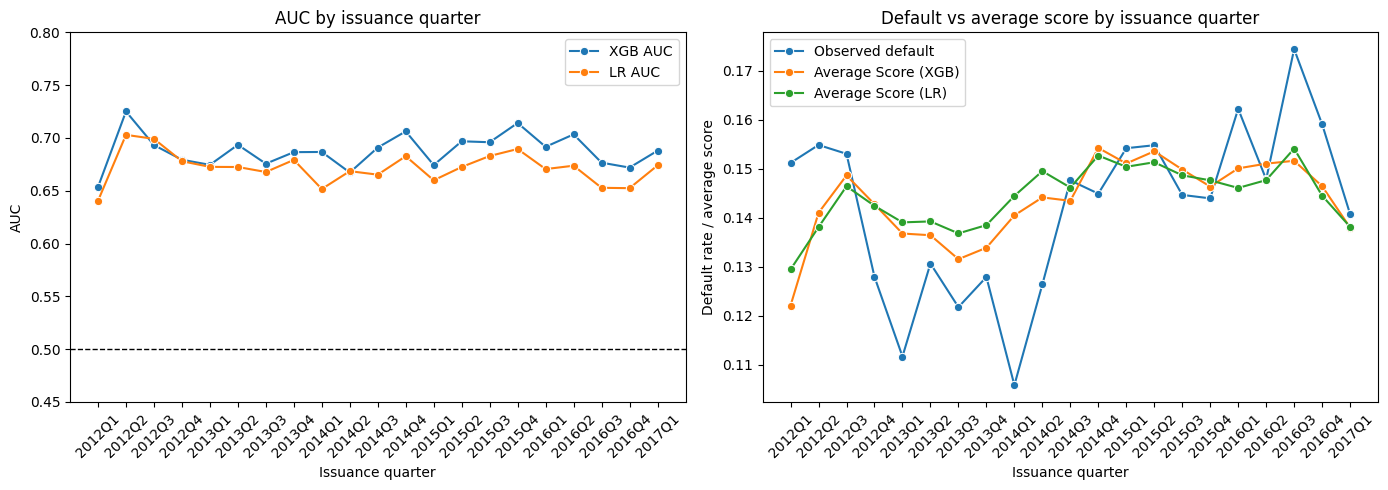

In [8]:
current_evaluation_data = pd.concat([calibration_data, validation_data])
current_evaluation_data["issue_quarter"] = (
    current_evaluation_data["loan_issue_date"].dt.to_period("Q").astype(str)
)


def get_quarter_metrics(df):
    return pd.Series(
        {
            "count": len(df),
            "default_rate": df["default_binary"].mean(),
            "xgb_pred_mean": df["xgb_pred"].mean(),
            "lr_pred_mean": df["lr_pred"].mean(),
            "xgb_auc": (
                roc_auc_score(df["default_binary"], df["xgb_pred"])
                if pd.Series(df["default_binary"]).nunique() > 1
                else np.nan
            ),
            "lr_auc": (
                roc_auc_score(df["default_binary"], df["lr_pred"])
                if pd.Series(df["default_binary"]).nunique() > 1
                else np.nan
            ),
        }
    )


metrics = (
    current_evaluation_data.groupby("issue_quarter", group_keys=False)
    .apply(get_quarter_metrics, include_groups=False)
    .reset_index()
)
metrics["xgb_auc"] = pd.to_numeric(metrics["xgb_auc"], errors="coerce")
metrics["lr_auc"] = pd.to_numeric(metrics["lr_auc"], errors="coerce")
metrics["default_rate"] = pd.to_numeric(metrics["default_rate"], errors="coerce")
metrics["xgb_pred_mean"] = pd.to_numeric(metrics["xgb_pred_mean"], errors="coerce")
metrics["lr_pred_mean"] = pd.to_numeric(metrics["lr_pred_mean"], errors="coerce")
metrics = metrics.sort_values("issue_quarter")
metrics = metrics[metrics["issue_quarter"] >= "2012Q1"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.lineplot(data=metrics, x="issue_quarter", y="xgb_auc", marker="o", label="XGB AUC", ax=axes[0])
sns.lineplot(data=metrics, x="issue_quarter", y="lr_auc", marker="o", label="LR AUC", ax=axes[0])

axes[0].axhline(0.5, color="black", linestyle="--", linewidth=1)
axes[0].set_title("AUC by issuance quarter")
axes[0].set_ylim(0.45, 0.8)
axes[0].set_ylabel("AUC")
axes[0].set_xlabel("Issuance quarter")
axes[0].tick_params(axis="x", rotation=45)

sns.lineplot(
    data=metrics, x="issue_quarter", y="default_rate", marker="o", label="Observed default", ax=axes[1]
)
sns.lineplot(
    data=metrics, x="issue_quarter", y="xgb_pred_mean", marker="o", label="Average Score (XGB)", ax=axes[1]
)
sns.lineplot(
    data=metrics, x="issue_quarter", y="lr_pred_mean", marker="o", label="Average Score (LR)", ax=axes[1]
)

axes[1].set_title("Default vs average score by issuance quarter")
axes[1].tick_params(axis="x", rotation=45)
axes[1].set_ylabel("Default rate / average score")
axes[1].set_xlabel("Issuance quarter")

plt.tight_layout()

The quarterly AUC curves suggest that both models maintain reasonable discriminatory power over time, with XGBoost consistently outperforming logistic regression by a small but persistent margin. While there is quarter-to-quarter noise (which is expected, since some quarters may have smaller sample sizes or different borrower mix), neither model shows a collapse toward random performance (AUC ≈ 0.5). This is a good signal that the ranking logic learned by both models remains stable across issuance cohorts.

On the score dynamics side, the average predicted risk for both models generally moves in the same direction as the observed default rate, indicating that the models are at least capturing the macro-level swings in portfolio risk. However, the default rate itself is more volatile than the mean predicted score, which is common: average scores tend to be smoother and partially “regularized,” while realized defaults can jump due to external factors (economic shocks, policy changes, changes in delinquency definitions, etc.). This means that even when AUC is stable, score calibration and level alignment may still drift over time — so if the model is used operationally (cutoffs, pricing, limits), it would be important to later run calibration checks by cohort (e.g., Brier score, calibration curves, or observed vs predicted in risk bands).

Overall, this temporal view reinforces the earlier interpretability stability results: the models appear to rely on consistent risk signals over time and preserve ranking performance across cohorts. The remaining variation seems more consistent with portfolio and macro drift than with a fundamental change in model behavior, but it motivates monitoring score distributions and calibration on a rolling basis.

# Calibration and uncertainty-aware scores

Up to this point, we have primarily evaluated the models from a ranking and stability perspective (AUC, temporal robustness, and interpretability). However, in many real-world decision systems, it is equally important that predicted scores are well aligned with observed risk levels, especially when scores are used downstream for pricing, limits, or policy thresholds.

In this section, we assess probability calibration for both XGBoost and logistic regression. We compare raw model scores against calibrated scores using Venn–Abers calibration, which not only produces a calibrated point estimate, but also yields prediction intervals that quantify uncertainty around each individual prediction. While calibration is not always strictly necessary for ranking-based use cases, it becomes increasingly relevant when decisions depend on absolute risk levels or when uncertainty itself can be operationalized as a policy signal.

In [9]:
xgb_pred_positive_calibration = calibration_data["xgb_pred"].to_numpy()
xgb_pred_calibration = np.transpose(
    np.vstack((1 - xgb_pred_positive_calibration, xgb_pred_positive_calibration))
)

xgb_pred_positive = data["xgb_pred"].to_numpy()
xgb_pred = np.transpose(np.vstack((1 - xgb_pred_positive, xgb_pred_positive)))

calibration_target = calibration_data["default_binary"].to_numpy()

venn_abers_calibrator = VennAbers()

# fit on calibration data
venn_abers_calibrator.fit(xgb_pred_calibration, calibration_target)
clear_output()

# predict on data
calibrated_probs, calibrated_intervals = venn_abers_calibrator.predict_proba(xgb_pred)

data["xgb_pred_calibrated"] = calibrated_probs[:, 1]
data["xgb_pred_calibrated_lower"] = calibrated_intervals[:, 0]
data["xgb_pred_calibrated_upper"] = calibrated_intervals[:, 1]
data["xgb_pred_calibrated_width"] = data["xgb_pred_calibrated_upper"] - data["xgb_pred_calibrated_lower"]

In [10]:
lr_pred_positive_calibration = calibration_data["lr_pred"].to_numpy()
lr_pred_calibration = np.transpose(
    np.vstack((1 - lr_pred_positive_calibration, lr_pred_positive_calibration))
)

lr_pred_positive = data["lr_pred"].to_numpy()
lr_pred = np.transpose(np.vstack((1 - lr_pred_positive, lr_pred_positive)))

calibration_target = calibration_data["default_binary"].to_numpy()

venn_abers_calibrator = VennAbers()

# fit on calibration data
venn_abers_calibrator.fit(lr_pred_calibration, calibration_target)
clear_output()

# predict on data
calibrated_probs, calibrated_intervals = venn_abers_calibrator.predict_proba(lr_pred)

data["lr_pred_calibrated"] = calibrated_probs[:, 1]
data["lr_pred_calibrated_lower"] = calibrated_intervals[:, 0]
data["lr_pred_calibrated_upper"] = calibrated_intervals[:, 1]
data["lr_pred_calibrated_width"] = data["lr_pred_calibrated_upper"] - data["lr_pred_calibrated_lower"]

In [11]:
train_data = data[data["dataset"] == "train"]
calibration_data = data[data["dataset"] == "calibration"]
validation_data = data[data["dataset"] == "validation"]

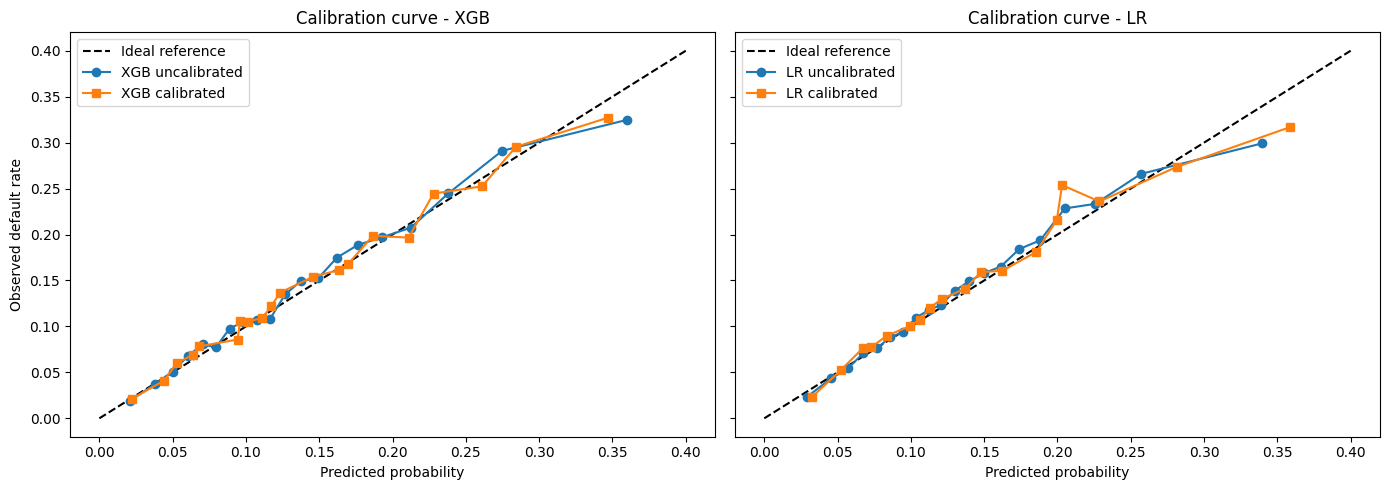

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

model_info = [("xgb_pred", "xgb_pred_calibrated", "XGB"), ("lr_pred", "lr_pred_calibrated", "LR")]

for i, (raw_col, cal_col, model_name) in enumerate(model_info):
    frac_pos_raw, mean_pred_raw = calibration_curve(
        validation_data["default_binary"], validation_data[raw_col], n_bins=20, strategy="quantile"
    )
    frac_pos_cal, mean_pred_cal = calibration_curve(
        validation_data["default_binary"], validation_data[cal_col], n_bins=20, strategy="quantile"
    )
    axes[i].plot([0, 0.4], [0, 0.4], "k--", label="Ideal reference")
    axes[i].plot(mean_pred_raw, frac_pos_raw, "o-", label=f"{model_name} uncalibrated")
    axes[i].plot(mean_pred_cal, frac_pos_cal, "s-", label=f"{model_name} calibrated")
    axes[i].set_xlabel("Predicted probability")
    if i == 0:
        axes[i].set_ylabel("Observed default rate")
    axes[i].set_title(f"Calibration curve - {model_name}")
    axes[i].legend()

plt.tight_layout()
plt.show()

In [13]:
validation_data[
    [
        "xgb_pred_calibrated",
        "xgb_pred_calibrated_lower",
        "xgb_pred_calibrated_upper",
        "xgb_pred_calibrated_width",
    ]
].sort_values(by="xgb_pred_calibrated_width", ascending=False).head(10).map(
    lambda x: f"{x:.1%}" if pd.notnull(x) else ""
)

,xgb_pred_calibrated,xgb_pred_calibrated_lower,xgb_pred_calibrated_upper,xgb_pred_calibrated_width
966370,65.2%,60.0%,75.0%,15.0%
962700,65.9%,61.1%,75.0%,13.9%
958255,65.9%,61.1%,75.0%,13.9%
957032,65.9%,61.1%,75.0%,13.9%
975710,65.9%,61.1%,75.0%,13.9%
953632,65.9%,61.1%,75.0%,13.9%
978460,58.6%,52.8%,66.7%,13.8%
965899,49.3%,44.5%,53.8%,9.3%
978263,49.3%,44.5%,53.8%,9.3%
982301,62.5%,60.0%,66.7%,6.7%


The calibration curves indicate that both models are already reasonably well calibrated before any post-processing, particularly in the low-to-mid risk regions. Applying Venn–Abers calibration leads to only marginal shifts in the average calibration curves, suggesting that neither model suffers from severe miscalibration. This reinforces the earlier conclusion that the models are learning stable and coherent risk signals, and that additional calibration is not strictly required to make their outputs usable at a high level.

That said, the value of Venn–Abers in this context is less about correcting the mean calibration curve and more about producing calibrated probabilities while also exposing where the model cannot determine those probabilities with high certainty. The calibrated lower and upper bounds returned by Venn–Abers can be interpreted as a multiprobability range: a signal of how well-determined the probability assignment is for each individual borrower given the available calibration data. In practice, especially in the higher-risk region, some borrowers receive noticeably wider ranges, indicating cases where the model’s score-to-probability mapping is more ambiguous. One plausible interpretation is that this region of the score space is inherently more ambiguous — both because fewer comparable observations exist and because the outcomes for similarly scored borrowers may be more heterogeneous. In real credit portfolios, very risky applicants are often subject to prior screening, rejection, or differentiated treatment driven by internal risk and business policies. As a result, the observed dataset is not a random sample of the underlying population, but rather the outcome of an existing selection mechanism. While this analysis cannot establish causality, the pattern is consistent with upstream risk policies shaping the data-generating process.

Beyond these multiprobability ranges, there are alternative approaches such as conformal prediction, which can generate explicit confidence intervals around predicted probabilities with user-defined coverage. This technique, for instance, could be used to create intervals that capture the range within which the true default probability is expected to lie, providing an additional layer of decision support for operational policies — such as in fraud detection or real-time credit assessment — by quantifying uncertainty at the individual prediction level. Borrowers with seemingly similar risk but wider or less confident intervals could be flagged for extra verification or subject to different treatment paths. Although these complementary methods could be integrated into future policy frameworks to make risk-based decision rules more robust and uncertainty-aware, a deep dive into conformal prediction and its implementation goes beyond the scope of this discussion.

# Segment-level error analysis

While global calibration curves provide a useful high-level view, they can obscure systematic errors that only emerge within specific regions of the feature space. To surface these localized effects, we perform a segment-level calibration gap analysis for both the XGBoost and Logistic Regression models.

For each feature, the validation data is partitioned into coarse segments (quantiles for numerical variables and categories for categorical ones). Within each segment, we compare the observed default rate to the average predicted probability, and compute a calibration gap. Segments are flagged only when three conditions are simultaneously met: (i) sufficient sample size, (ii) a material absolute gap, and (iii) statistical significance based on a confidence interval around the gap, relative to the feature’s weighted baseline behavior.

This approach allows us to identify localized regions where either model consistently under- or over-predicts risk, even when global metrics such as AUC or aggregate calibration curves appear satisfactory.

In [14]:
target_col = "default_binary"
xgb_pred_col = "xgb_pred_calibrated"
lr_pred_col = "lr_pred_calibrated"

min_segment_size = 500
min_gap = 0.005
min_delta_vs_baseline = 0.005
z_score = 1.96

In [15]:
def segmented_error_analysis(
    validation_data,
    feature_list,
    pred_col,
    target_col="default_binary",
    min_segment_size=500,
    min_gap=0.005,
    min_delta_vs_baseline=0.005,
    z_score=1.96,
    n_quantiles=5,
):
    """
    Perform segmented error analysis by feature on model predictions.

    For each feature in feature_list, splits validation_data into buckets
    (quantiles for numeric, value groups for categorical), computes observed and
    predicted default rates, and flags segments with statistically significant and
    nontrivial calibration gaps, compared to the overall baseline.

    This helps identify where the model systematically underpredicts or overpredicts risk.

    Parameters
    ----------
    validation_data : DataFrame
        Validation set with features, predictions, and target.
    feature_list : list of str
        Features to segment on.
    pred_col : str
        Column name with predicted probabilities.
    target_col : str, default "default_binary"
        Binary target column name.
    min_segment_size : int, default 500
        Minimum size for a segment to be analyzed.
    min_gap : float, default 0.005
        Minimum absolute calibration gap needed to consider a segment.
    min_delta_vs_baseline : float, default 0.005
        Minimum difference vs. baseline to flag a gap as material.
    z_score : float, default 1.96
        Z-value for confidence intervals (1.96 ≅ 95%).
    n_quantiles : int, default 5
        Number of quantile bins for numeric features.

    Returns
    -------
    pd.DataFrame
        Table with feature, segment, statistics, gap magnitude, confidence intervals,
        direction ("underpredict"/"overpredict"), and other details, sorted by absolute gap vs baseline.
    """
    segmented_results = []

    for feature in feature_list:
        # Skip if feature not present or not enough unique values to segment
        if feature not in validation_data.columns:
            continue
        series = validation_data[feature]
        if series.nunique(dropna=True) < 2:
            continue

        # For numeric features: quantile binning. For categorical: use as is.
        if pd.api.types.is_numeric_dtype(series):
            try:
                quantile_bins = pd.qcut(series, q=n_quantiles, duplicates="drop")
                bin_indices = quantile_bins.cat.codes + 1  # Bin number (1-indexed)
                bin_labels = quantile_bins.astype(str)
                segment_bucket = bin_indices.astype(str) + " (" + bin_labels + ")"
            except Exception:
                continue
        else:
            segment_bucket = series.astype(str).fillna("MISSING")

        temp_df = validation_data[[target_col, pred_col]].copy()
        temp_df["segment_bucket"] = segment_bucket

        # Aggregate observed and predicted rates per segment
        segment_stats = (
            temp_df.groupby("segment_bucket", dropna=False)
            .agg(
                count=(target_col, "size"),
                observed_default_rate=(target_col, "mean"),
                predicted_default_rate=(pred_col, "mean"),
                predicted_var=(pred_col, "var"),
            )
            .reset_index()
        )

        segment_stats = segment_stats[segment_stats["count"] >= min_segment_size]
        if segment_stats.empty:
            continue

        # Calibration gap: actual minus predicted default rates
        segment_stats["calibration_gap"] = (
            segment_stats["observed_default_rate"] - segment_stats["predicted_default_rate"]
        )

        # Calculate confidence intervals for the gap (binomial error + prediction variance)
        p = segment_stats["observed_default_rate"].clip(1e-9, 1 - 1e-9)
        se_observed = np.sqrt(p * (1 - p) / segment_stats["count"])
        se_pred = np.sqrt(segment_stats["predicted_var"].fillna(0) / segment_stats["count"])
        se_total = np.sqrt(se_observed**2 + se_pred**2)

        segment_stats["gap_confidence_low"] = segment_stats["calibration_gap"] - z_score * se_total
        segment_stats["gap_confidence_high"] = segment_stats["calibration_gap"] + z_score * se_total

        # Weighted mean for feature-specific gap ("baseline")
        group_weights = segment_stats["count"] / segment_stats["count"].sum()
        baseline_gap = (segment_stats["calibration_gap"] * group_weights).sum()

        # How much is this bucket's gap above/below baseline?
        segment_stats["gap_vs_baseline"] = segment_stats["calibration_gap"] - baseline_gap

        # Flag statistically significant and practically relevant gaps
        filter_mask = (
            (segment_stats["calibration_gap"].abs() >= min_gap)
            & ((segment_stats["gap_confidence_low"] > 0) | (segment_stats["gap_confidence_high"] < 0))
            & (segment_stats["gap_vs_baseline"].abs() >= min_delta_vs_baseline)
        )

        flagged_segments = segment_stats.loc[filter_mask].copy()
        if flagged_segments.empty:
            continue

        flagged_segments["feature"] = feature
        flagged_segments["baseline_gap"] = baseline_gap
        flagged_segments["volume_share"] = flagged_segments["count"] / len(validation_data)
        flagged_segments["direction"] = np.where(
            flagged_segments["calibration_gap"] > 0, "underpredict", "overpredict"
        )

        segmented_results.append(
            flagged_segments[
                [
                    "feature",
                    "segment_bucket",
                    "count",
                    "volume_share",
                    "observed_default_rate",
                    "predicted_default_rate",
                    "calibration_gap",
                    "baseline_gap",
                    "gap_vs_baseline",
                    "gap_confidence_low",
                    "gap_confidence_high",
                    "direction",
                ]
            ]
        )

    # Concatenate all flagged segments and sort by biggest absolute gap vs. baseline
    final_error_analysis = (
        pd.concat(segmented_results, ignore_index=True) if segmented_results else pd.DataFrame()
    )

    final_error_analysis = final_error_analysis.sort_values(
        "gap_vs_baseline", key=np.abs, ascending=False
    ).reset_index(drop=True)

    return final_error_analysis

In [16]:
display(segmented_error_analysis(validation_data, XGBOOST_FEATURES, xgb_pred_col).head(50))

,feature,segment_bucket,count,volume_share,observed_default_rate,predicted_default_rate,calibration_gap,baseline_gap,gap_vs_baseline,gap_confidence_low,gap_confidence_high,direction
0,xgb_employment_length_years,0 (nan),3868,0.080748,0.208376,0.193569,0.014808,0.002201,0.012607,0.001679,0.027936,underpredict
1,xgb_loan_amount_requested,"4 ((12000.0, 20000.0])",10320,0.215440,0.152229,0.139001,0.013227,0.002201,0.011027,0.006088,0.020366,underpredict
2,xgb_average_current_balance,"2 ((2416.2, 4644.0])",9582,0.200033,0.172720,0.160342,0.012378,0.002201,0.010178,0.004612,0.020144,underpredict
3,xgb_total_installment_credit_limit,"5 ((65136.8, 1285625.0])",9581,0.200013,0.119716,0.127118,-0.007402,0.002201,-0.009602,-0.014111,-0.000693,overpredict
4,xgb_revolving_utilization_rate,"1 ((-0.001, 0.264])",9587,0.200138,0.101492,0.107892,-0.006401,0.002226,-0.008627,-0.012661,-0.000141,overpredict
5,xgb_months_since_oldest_revolving,"5 ((259.0, 781.0])",9486,0.198029,0.126291,0.116302,0.009990,0.002201,0.007789,0.003125,0.016855,underpredict
6,xgb_bankcard_open_to_buy,"3 ((4011.2, 8531.2])",9479,0.197883,0.155713,0.146189,0.009523,0.002201,0.007323,0.002048,0.016999,underpredict
7,xgb_revolving_balance,"4 ((13323.6, 22017.8])",9580,0.199992,0.148956,0.139490,0.009466,0.002201,0.007266,0.002144,0.016789,underpredict
8,xgb_bankcard_utilization,"4 ((66.7, 85.3])",9465,0.197591,0.159113,0.149801,0.009311,0.002201,0.007111,0.001768,0.016855,underpredict
9,xgb_total_balance_excluding_mortgage,"4 ((43737.0, 70255.4])",9579,0.199971,0.145213,0.136047,0.009166,0.002201,0.006966,0.001914,0.016418,underpredict


In [17]:
display(segmented_error_analysis(validation_data, LR_FEATURES, lr_pred_col).head(50))

,feature,segment_bucket,count,volume_share,observed_default_rate,predicted_default_rate,calibration_gap,baseline_gap,gap_vs_baseline,gap_confidence_low,gap_confidence_high,direction
0,lr_loan_amount_requested,"5 ((0.842, 1.0])",8030,0.167634,0.152179,0.133196,0.018983,0.002467,0.016516,0.010957,0.027009,underpredict
1,lr_months_since_recent_inquiry,"1 ((-0.001, 0.08])",11061,0.230909,0.176385,0.160651,0.015735,0.002467,0.013268,0.008473,0.022996,underpredict
2,lr_total_bankcard_limit,"1 ((-0.001, 0.637])",9668,0.201829,0.163322,0.173210,-0.009888,0.002467,-0.012354,-0.017403,-0.002373,overpredict
3,lr_loan_amount_requested,"2 ((0.544, 0.645])",9573,0.199846,0.133187,0.142840,-0.009653,0.002467,-0.012120,-0.016623,-0.002683,overpredict
4,lr_percent_bankcard_over_75pct_limit,"3 ((0.5, 0.75])",6137,0.128116,0.169464,0.156047,0.013417,0.002467,0.010950,0.003858,0.022976,underpredict
5,lr_bankcard_open_to_buy,"1 ((-0.001, 0.555])",9581,0.200013,0.163970,0.172251,-0.008280,0.002467,-0.010747,-0.015836,-0.000725,overpredict
6,lr_months_since_oldest_revolving,"5 ((0.287, 0.867])",9486,0.198029,0.126291,0.113332,0.012960,0.002467,0.010493,0.006132,0.019788,underpredict
7,lr_months_since_recent_inquiry,"2 ((0.08, 0.2])",14989,0.312910,0.129095,0.136944,-0.007849,0.002467,-0.010316,-0.013354,-0.002345,overpredict
8,lr_months_since_oldest_revolving,"3 ((0.16, 0.211])",9576,0.199908,0.124896,0.132234,-0.007338,0.002467,-0.009805,-0.014121,-0.000556,overpredict
9,lr_revolving_balance,"4 ((0.638, 0.672])",9580,0.199992,0.148956,0.136877,0.012079,0.002467,0.009612,0.004796,0.019361,underpredict


Across both XGBoost and Logistic Regression, the flagged segments exhibit a coherent and intuitive pattern. Most statistically significant gaps correspond to higher-risk regions of the feature space, such as larger loan amounts, higher utilization or balance measures, shorter credit histories, and more recent credit-seeking behavior. In these regions, both models tend to underpredict default risk, while a smaller number of lower-risk segments show mild overprediction. Importantly, these effects persist after controlling for baseline feature behavior, indicating that they are not artifacts of overall calibration noise.

The similarity of the findings across models is notable. Despite their very different functional forms, both XGBoost and Logistic Regression highlight overlapping features and segments as calibration-sensitive. This suggests that the observed gaps are driven less by model misspecification and more by structural properties of the data itself. In particular, the concentration of underprediction in higher-risk segments is consistent with the presence of upstream credit and risk policies: borrowers in extreme regions are more likely to be filtered, capped, or selectively approved, which leads to non-random outcome distributions and noisier empirical default rates in those slices.

From a modeling and governance perspective, these results reinforce two points. First, global calibration metrics alone are insufficient to assess real-world risk behavior; conditional analyses are necessary to uncover where predictions may systematically deviate from realized outcomes. Second, the alignment between XGBoost and Logistic Regression strengthens confidence that the models are learning stable, economically meaningful risk patterns rather than exploiting spurious correlations. While the magnitude of the observed gaps does not necessarily call for immediate remediation, this framework provides a principled basis for targeted monitoring, policy overlays, or additional controls in segments where prediction uncertainty and business risk are highest.

Next, we will move on to the policy section, where we'll use these findings to define strategies and decision criteria — covering objectives, risk segmentation, expected loss, approval trade-offs, policy cutoffs, and key assumptions for responsible credit decisioning.

In [18]:
data.to_parquet("../data/scored_calibrated_data.parquet")